### In this notebook, we demonstrate the how to construct text networks and analyze them. the notebook is broken into five sections that begin with preprocessing the text and conclude with additional analyses around the computation of text simialrities at a sentence-level.

In [ ]:
# install any neccesary packages

! pip install contractions Levenshtein fuzzywuzzy
! pip install scikit-network
! pip install pymongo
! python -m spacy download en_core_web_lg

In [110]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import SVG
from functools import reduce
from itertools import product

import importlib, sys, pandas as pd, numpy as np, spacy, re, itertools, pickle, string
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralCoclustering
from sklearn.base import ClusterMixin

from Levenshtein import distance as l_dist
from fuzzywuzzy import fuzz
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import sknetwork as skn

# 1. Import and Process Data
For this section, the main tasks are:
- import the data
- pre-process to remove bad text
- split each text into sentences and add in the titles

In [48]:
# This cell loads the Spacy library with the `en_core_web_lg` model and adds a sentence tokenization pipe. It also sets the maximum length of text that can be processed.

nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("sentencizer")
#nlp.add_pipe("merge_entities")
nlp.max_length = 3000000

In [49]:
def process_text(text): 
    '''
    Preprocesses input text and returns a list of cleaned and processed sentences.

    Parameters:
    text (str): A string of text to be processed.

    Returns:
    list: A list of cleaned and processed sentences.
    '''
    
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace(
        "&lt;", "<").replace("Loading Something is loading", "") #filler from business inside articles
    text = re.sub(r"http\S+", "", text)
    #change new lines into sentences
    text = re.sub("\n", ". ", text)
    text = re.sub("\.\.", ".", text)
    text = re.sub("\. \.", ".", text)
    #text = contractions.fix(text)
    text = nlp(text) #run through senticizer and merge entities pipe
    sentences = [i for i in text.sents if len(i) >2 ]
    #remove  filler sentences (avoid learning the article metadata)
    junk_list = ["this advertisement","the unsubscribe link", "your junk folder", "your inbox", "free streaming app",
                "download and start watching", "click here", "subscribe", "load error", "replay video", "please follow us on",
                "go ad free"] 
    sentences = [i for i in sentences if not str(i).isupper()]
    sentences = [i for i in sentences if not any(junk in str(i).lower() for junk in junk_list)]
    sentences = [i.text for i in sentences]
    return sentences

In [50]:
# Specify a dataset to read in

dataset_name = "mil_vaccine_religious_exemptions"

In [51]:
df = pd.read_csv(dataset_name+".csv")

In [52]:
df["processed_text"] = df.apply(lambda x: process_text(x['text']) if x['title'] is not str else process_text(x['title'] +". "+ x['text']), axis=1)

# 2. Measure Similarity Between Texts
In this section we demonstrate our technique for creating text networks. To compare the articles, this section does the following:
- create an 'alphabet' between two texts to uniquely ID sentences
- use edit distance to measure the distance between two texts
- convert distance to similarity

In [53]:
class Text_Similarity:
    def __init__(self, semantic_threshold=0.6, sentiment_threshold=0.1, 
                 embedding_model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2'),
                 method='ordered'):
        '''
        Class initializer for Text_Similarity.

        Args:
        - semantic_threshold (float): threshold for semantic similarity between sentences
        - sentiment_threshold (float): threshold for sentiment similarity between sentences
        - embedding_model (object): object for sentence embedding model
        - method (str): method for text similarity calculation ('ordered' or 'unordered')

        Returns:
        - None
        '''
        self.semantic_threshold = semantic_threshold
        self.sentiment_threshold = sentiment_threshold
        self.embedding_model = embedding_model
        self.method = method

    def get_text_similarity(self, article_1, article_2):
        '''
        Expects two articles that are lists of the sentences of the articles and
        returns a similarity score between the two texts.

        Args:
        - article_1 (list): list of sentences from first article
        - article_2 (list): list of sentences from second article

        Returns:
        - sim (float): similarity score between the two texts
        '''
        # Get the embeddings and sentiments of the two articles
        embeddings_1, sentiments_1 = self._get_text_embeddings(article_1)
        embeddings_2, sentiments_2 = self._get_text_embeddings(article_2)
        
        # Get pairwise cosine similarity between the sentence embeddings of the two articles and 
        # the absolute difference in their sentiment scores. Then only make matches of those above or
        # below the threshold values
        matches = np.argwhere((cosine_similarity(embeddings_1, embeddings_2) > self.semantic_threshold) &
                             (manhattan_distances(sentiments_1, sentiments_2) < self.sentiment_threshold))
        if self.method == "ordered":
            sim = self._get_edit_similarity(embeddings_1, embeddings_2, matches)
        elif self.method == "unordered":
            sim = self._get_overlap_similarity(embeddings_1, embeddings_2, matches)
        else:
            raise("method must be 'ordered' or 'unordered'")
            
        return sim
    
    def _get_text_embeddings(self, article):
        '''
        Helper method to get sentence embeddings and sentiment scores of an article.

        Args:
        - article (list): list of sentences from an article

        Returns:
        - embeddings (ndarray): array of sentence embeddings
        - sentiments (ndarray): array of sentiment scores
        '''
        embeddings = self.embedding_model.encode(article)
        sid = SentimentIntensityAnalyzer()
        sentiments = np.array([sid.polarity_scores(sent)['compound'] for sent in article])
        return embeddings, sentiments.reshape(-1, 1)
        
    def _get_edit_similarity(self, embeddings_1, embeddings_2, matches):
        '''
        Helper method to calculate similarity between two texts using ordered matching.

        Args:
        - embeddings_1 (ndarray): array of sentence embeddings from first article
        - embeddings_2 (ndarray): array of sentence embeddings from second article
        - matches (ndarray): array of matching sentence pairs between two articles

        Returns:
        - sim (float): similarity score between the two texts
        '''
        article_1_dict = {}
        article_2_dict = {}

        # initialize an alphabet
        alphabet = list(string.ascii_lowercase + string.ascii_uppercase  + string.digits + "!@#$%^&*()-+=<>?:;"+ "".join([chr(i) for i in range(161,10000)]))

        # assign alphabet characters to those sentences that match across articles
        for i in range(len(matches)):
            symbol = alphabet.pop(0)
            article_1_dict[matches[i][0]] = symbol
            article_2_dict[matches[i][1]] = symbol

        # create the sentence strings of the articles, making sure that mathcing sentences have the same character
        # and non-matching sentences get a character that is unique across both docuements
        article_1_string = "".join([article_1_dict[i] if i in article_1_dict else alphabet.pop(0) for i in range(len(embeddings_1))])
        article_2_string = "".join([article_2_dict[i] if i in article_2_dict else alphabet.pop(0) for i in range(len(embeddings_2))])

        # calculate the edit distance between the articles (i.e. how much do sentences need to change to make one article look like another)
        sim = fuzz.partial_ratio(article_1_string, article_2_string)/100
        return sim
    
    def _get_overlap_similarity(self, embeddings_1, embeddings_2, matches):
        '''
        Helper method to calculate similarity between two texts using unordered matching.

        Args:
        - embeddings_1 (ndarray): array of sentence embeddings from first article
        - embeddings_2 (ndarray): array of sentence embeddings from second article
        - matches (ndarray): array of matching sentence pairs between two articles

        Returns:
        - sim (float): similarity score between the two texts
        '''
        return len(matches)/ min(len(embeddings_1), len(embeddings_2))

In [54]:
article_similarities = []
text_sim = Text_Similarity(method="ordered")
for i in range(len(df)):
    for j in range(i+1,len(df)):
        article_similarities.append((df['base_url'][i], df['base_url'][j], text_sim.get_text_similarity(df['processed_text'][i], df['processed_text'][j])))

# 3. Cluster Analysis of the texts Based on Pairwise Similarity
In this section we analyze the clusters that emerge from the text networks of the articles, both at the article and the URL domain level

In [55]:
# Create the text network for articles

graph = skn.data.from_edge_list(article_similarities, directed=False, weighted=True)

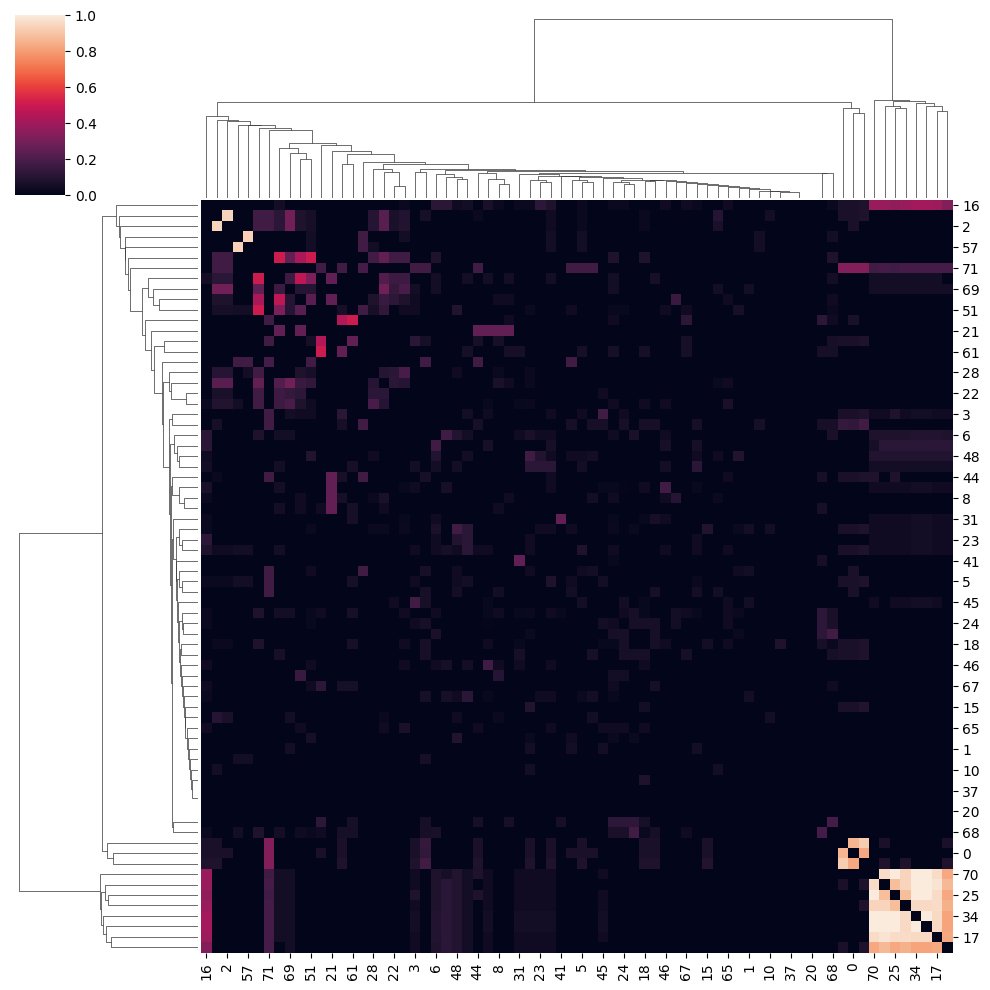

In [56]:
sns.clustermap(graph.adjacency.todense())

In [63]:
# Cluster the articles text network

louvain = skn.clustering.Louvain()
clusters = louvain.fit_predict(graph.adjacency)

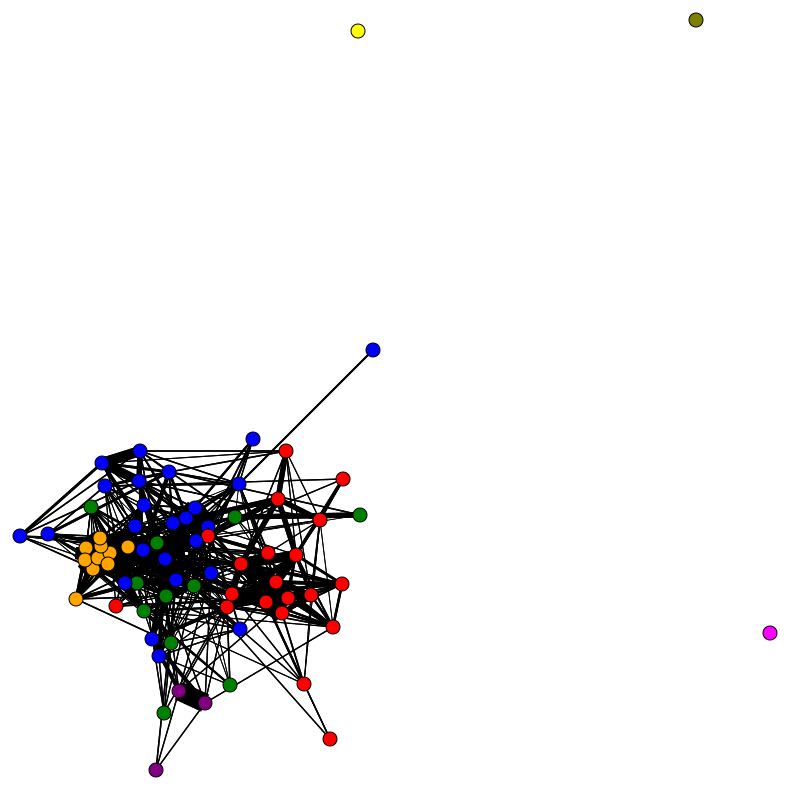

In [111]:
image = skn.visualization.svg_graph(graph.adjacency, labels=clusters, width=750, height=750)
SVG(image)

In [112]:
df['article_clusters'] = clusters

In [113]:
print("ARI between Document Clusters and Domain Biases: {}".format(adjusted_rand_score(df['Bias'], df['article_clusters'])))

ARI between Document Clusters and Domain Biases: 0.02405301533593421


In [114]:
print("Modularity of Bias : {}".format(skn.clustering.get_modularity(graph.adjacency, df['Bias'].astype('category').cat.codes.values)))

Modularity of Bias : 0.0018655776519649614


In [505]:
# Save out the network information

df['base_url'] = df['base_url'].apply( lambda x: x[8:])
df[['base_url', 'domain', 'Bias', 'article_clusters']].to_csv(dataset_name+"_article_node_info.csv", index=False)
pd.DataFrame(graph.adjacency.todense(), index=[i[8:] for i in graph.names], columns=[i[8:] for i in graph.names]).to_csv(dataset_name+"_article_adjacency.csv")

### Now, we perform a cluster analysis of domains by pairwise similarity of texts
To get the domain to domain text graph we induce domain similarity using text similarities. 

In [115]:
domain_to_article_graph = skn.data.from_edge_list(list(df[['domain', 'base_url']].itertuples(index=False, name=None)), bipartite=True)

In [116]:
# Inducing the domain to domain text similiarity graph

domain_to_domain_graph = np.sqrt(domain_to_article_graph.biadjacency)  * graph.adjacency * np.sqrt(domain_to_article_graph.biadjacency).T

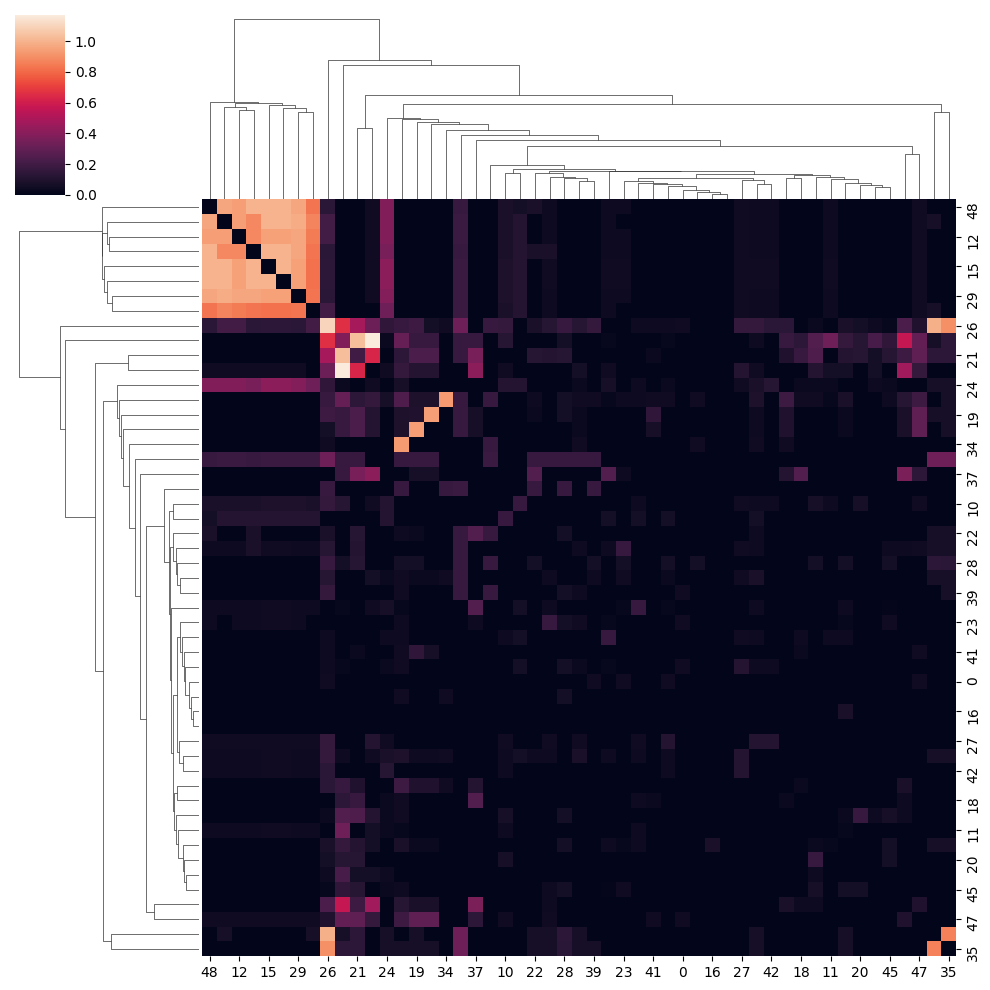

In [117]:
sns.clustermap(domain_to_domain_graph.todense())

In [118]:
louvain = skn.clustering.Louvain()
domain_clusters = louvain.fit_predict(domain_to_domain_graph)

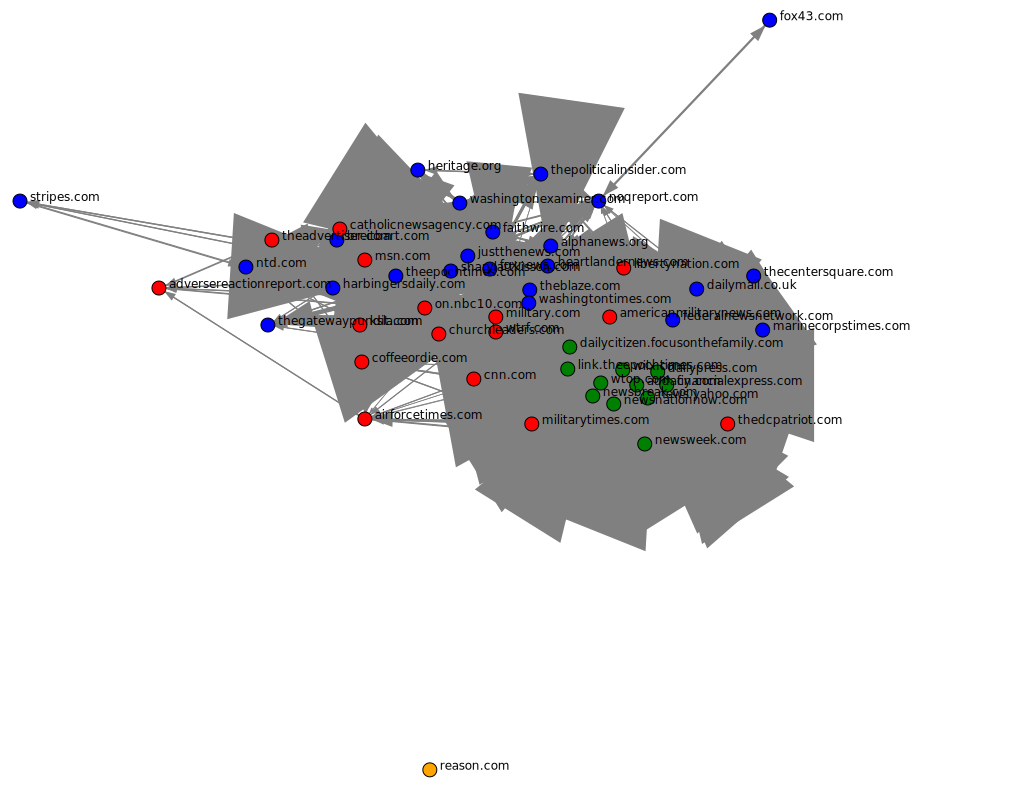

In [119]:
image = skn.visualization.svg_graph(domain_to_domain_graph, names=domain_to_article_graph.names_row, labels=domain_clusters, width=750, height=750)
SVG(image)

In [120]:
domain_df = pd.DataFrame({"domain":domain_to_article_graph.names_row, "domain_clusters":domain_clusters}).merge(df[['domain','Bias']].drop_duplicates(subset='domain'), on="domain", how="left")

In [121]:
print("ARI between Induced Domain Clusters and Domain Biases: {}".format(adjusted_rand_score(domain_df ['Bias'], domain_df ['domain_clusters'])))

ARI between Induced Domain Clusters and Domain Biases: 0.09931965776724049


In [122]:
print("Modularity of Bias : {}".format(skn.clustering.get_modularity(domain_to_domain_graph, domain_df['Bias'].astype('category').cat.codes.values)))

Modularity of Bias : 0.07451712330352928


In [514]:
# Save out the network information

domain_df.to_csv(dataset_name+"_domain_node_info.csv", index=False)
pd.DataFrame(domain_to_domain_graph.todense(), index=domain_to_article_graph.names_row, columns=domain_to_article_graph.names_row).to_csv(dataset_name+"_domain_adjacency.csv")

### Now, we do an ensemble clustering of domains across the different data sets to get a better sense of their more persistent writing-style biases

In [123]:
class LWBG(ClusterMixin):
    """Locally Weighted Bipartite Graph Partitioning Algorithm 
    
    LWBG : treat the objects-by-base clsuters as a bipartite graph 
    partitioning problem. In this case the bipartite graph is weighted by 
    information-thoeretic measures
    
    Parameters
    ----------
    base_clusters : list of array_like or pandas dataframe
        List of cluster labels where each set of labels must be in the same order
        and have shape (n_objects,). Note: standard output from sci-kit learn 
        clustering algorithms will return this format. If pandas dataframe, 
        should be shape (n_objects, n_clusters)
    metaclustering_alg : string
        string to denote how to cluster the object-to-object cluster association
        graph. Options are: 'louvain' and 'spectral'. Default is 'louvain'
    n_clusters : (int,int)
        Number of clusters to find to find for the objects and the base clusters. 
        Used only for spectral. Default is None
    theta : float
        Controls the impact of the local weighting. Default is 0.5
    
    Returns
    -------
    z : ndarray
        cluster labels of shape (n,).
    """
    
    def __init__(self, metaclustering_alg = 'louvain', n_clusters = (None,None),
                 theta = 0.5):
        
        self.metaclustering_alg = metaclustering_alg
        self.n_clusters = n_clusters
        self.theta = theta
    
    def fit_predict(self, base_clusters):
        ba_matrices =[]
        idxs = []
        idxs_iter = 0
        
        if isinstance(base_clusters, pd.DataFrame):
            base_clusters = [base_clusters.loc[:,i].to_numpy(dtype=int) for i in base_clusters.columns]
        else:
            base_clusters = [clustering.astype(np.int64) for clustering in base_clusters]
        
        for base_cluster in base_clusters:
            ba_matrix = np.zeros((base_cluster.size, base_cluster.max()+1))
            ba_matrix[np.arange(base_cluster.size), base_cluster] = 1
            ba_matrices.append(ba_matrix)
            idxs.append([idxs_iter, idxs_iter+ba_matrix.shape[1]])
            idxs_iter += ba_matrix.shape[1]
            
        ba_matrix = np.concatenate(ba_matrices, axis=1)
        
        H_matrix = np.zeros((ba_matrix.shape[1], len(ba_matrices)))
        final_clusterer = meta_alg()       
        
        for col_idx in range(ba_matrix.shape[1]):
            for mode in range(len(idxs)):
                idx = idxs[mode]
                if idx[0] <= col_idx <=idx[1]:
                    pass
                else:
                    H_m = []
                    for alt_idx in range(idx[0], idx[1]):
                        C_i = ba_matrix[:,col_idx]
                        C_j = ba_matrix[:,alt_idx]
                        P_ij = np.dot(C_i, C_j)/ np.count_nonzero(C_i)
                        if P_ij > 0:
                            H_m.append(P_ij * np.log2(P_ij))
                        else:
                            H_m.append(0)
                    H_matrix[col_idx, mode] = -1*np.sum(H_m)
        
        ECI = np.exp(-1* np.sum(H_matrix, axis=1)/(self.theta*len(ba_matrices)))
        weighted_ba_matrix = ba_matrix * ECI
        self.obj_clusters, self.cluster_clusters = final_clusterer.cluster(weighted_ba_matrix, self.n_clusters, self.metaclustering_alg)
        return self.obj_clusters
    
    
    # def _get_weighted_subgroup_counts(self, a, cluster_weights):    
    #     N = a.max()+1
    #     weighted_counts = np.zeros((a.shape[0], N-1))
    #     for label in range(1,N):
    #         label_counts = (a==label) * cluster_weights
    #         normalization = np.count_nonzero(np.sum(a == label, axis=0) >0)
    #         weighted_counts[:,label-1] = np.sum(label_counts, axis=1)/normalization
    #     return weighted_counts
        
    
class meta_alg:
    '''
    Factory class that does the clustering of the bipartite graphs for the other
    method classes
    '''
    
    def cluster(self, graph, n_clusters, format):
        clustering = self._get_clustering(format)
        return clustering(graph, n_clusters)
    
    def _get_clustering(self, format):
        if format == 'louvain':
            return self._graph_louvain
        elif format == 'spectral':
            return self._spectral
        else:
            raise ValueError(format)
            
    def _spectral(self, graph, n_clusters):
        clstr = SpectralCoclustering(n_clusters=n_clusters).fit(graph)
        return clstr.row_labels_, clstr.column_labels_
    
    def _graph_louvain(self, graph, n_clusters):
        clstr = skn.clustering.Louvain()
        clstr.fit(graph)
        return clstr.labels_row_, clstr.labels_col_

In [125]:
# Bring in the cluster for all of the datasets

df_list = [pd.read_csv(i+"_domain_node_info.csv") for i in ['mil_vaccine_air_force_cadets', 'mil_vaccine_navy_seals', 'mil_vaccine_religious_exemptions']]

In [126]:
bias_df = reduce(lambda x, y: pd.merge(x, y, on = 'domain', how='left'), df_list).drop_duplicates(subset='domain').set_index('domain')
bias_df = bias_df[[i for i in bias_df.columns if i[:4] == 'Bias']].bfill(axis=1).iloc[:, 0].rename('Bias')

In [128]:
# Combine the clusterings together and assign a no-closter value (-1) when a domain is not present in a particualr dataset

clusterings = [df_list[i][['domain', 'domain_clusters']] for i in range(len(df_list))]
clusterings_df = reduce(lambda x, y: pd.merge(x, y, on = 'domain', how='outer'), clusterings).drop_duplicates(subset='domain').fillna(value=-1).set_index('domain')

In [129]:
ensembler = LWBG()
clusterings_df['event_ensemble_clusters'] = ensembler.fit_predict(clusterings_df)

In [130]:
clusterings_df = clusterings_df.merge(bias_df, left_index=True, right_index=True)

In [131]:
print("ARI between Ensembled Domain Clusters and Domain Biases: {}".format(adjusted_rand_score(clusterings_df['Bias'], clusterings_df['event_ensemble_clusters'])))

ARI between Ensembled Domain Clusters and Domain Biases: 0.09155433762899323


# 4. Sensitivity Analysis of Thresholds
In this section we analyze how sensitive the method is to the two threshold hyperparameters
- __Part 1__: Create test networks. So, for each data set
    - create graphs at varying levels of thresholds
    - measure the distances between those graphs
- __Part 2__: visualize heatmaps of the averages across datasets of the different data sets

### Part 1

In [204]:
def spectral_graph_distance(a_1, a_2):
    m_ij = min(a_1.shape[0], a_2.shape[0])
    eig = skn.embedding.Spectral(n_components=m_ij)
    distanace = (1/(m_ij-1))*np.sum(np.abs(eig.fit_transform(a_1)[1:], eig.fit_transform(a_2)[1:]))
    return distanace

In [205]:
def normalized_hamming_graph_distance(a_1, a_2):
    m_ij = min(a_1.shape[0], a_2.shape[0])
    distanace = np.sum(np.abs(a_1- a_2))/(m_ij*(m_ij-1))
    return distanace

In [206]:
networks =[]
for tau_1, tau_2 in product(np.linspace(0.1, 0.99, num=7), np.linspace(0.1, 0.99, num=7)):
    article_similarities = []
    text_sim = Text_Similarity(method="ordered", semantic_threshold=tau_1, sentiment_threshold=tau_2)
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            article_similarities.append((df['base_url'][i], df['base_url'][j], text_sim.get_text_similarity(df['processed_text'][i], df['processed_text'][j])))
    networks.append((tau_1, tau_2, skn.data.from_edge_list(article_similarities, directed=False, weighted=True).adjacency))

In [207]:
network_similarities = []
for i in range(len(networks)):
    for j in range(i+1,len(networks)):
        network_similarities.append((networks[i][0], networks[i][1], networks[j][0], networks[j][1], 
                                    normalized_hamming_graph_distance(networks[i][2], networks[j][2]),
                                    spectral_graph_distance(networks[i][2], networks[j][2])
                                          ))

In [208]:
pd.DataFrame(network_similarities, columns=["tau_1_1", "tau_2_1", "tau_1_2", "tau_2_2", "L1_distance", "spectral_distance"]).to_csv("religious_exemptions_sensitivity.csv")

### Part 2

In [215]:
sen_df = pd.concat(
    [ pd.read_csv("air_force_cadet_sensitivity.csv"),
     pd.read_csv("navy_seals_sensitivity.csv"),
     pd.read_csv("religious_exemptions_sensitivity.csv")
    ]
)

In [216]:
tau_1_res = sen_df.groupby(["tau_1_1", "tau_1_2"]).agg({"L1_distance":"mean"})

In [217]:
tau_1_dis_matrix = skn.data.from_edge_list([(tau_1_res.index.values[i][0], tau_1_res.index.values[i][1], tau_1_res.values[i][0]) for i in range(len(tau_1_res))], directed=False, weighted=True)

<Axes: >

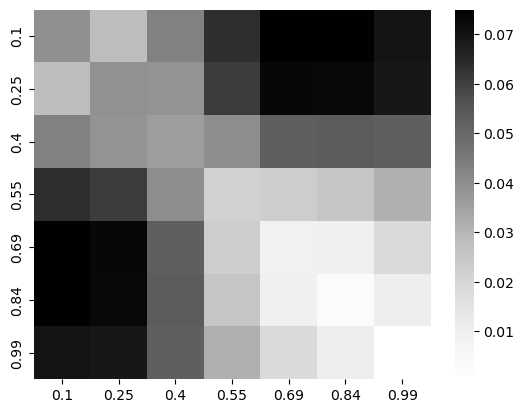

In [218]:
sns.heatmap(data=pd.DataFrame(tau_1_dis_matrix.adjacency.todense(), 
                              index=[np.around(i, decimals=2) for i in tau_1_dis_matrix.names], 
                              columns=[np.around(i, decimals=2) for i in tau_1_dis_matrix.names]),
           cmap="Greys")

In [219]:
tau_2_res = sen_df.groupby(["tau_2_1", "tau_2_2"]).agg({"L1_distance":"mean"})

In [220]:
tau_2_dis_matrix = skn.data.from_edge_list([(tau_2_res.index.values[i][0], tau_2_res.index.values[i][1], tau_2_res.values[i][0]) for i in range(len(tau_2_res))], directed=False, weighted=True)

<Axes: >

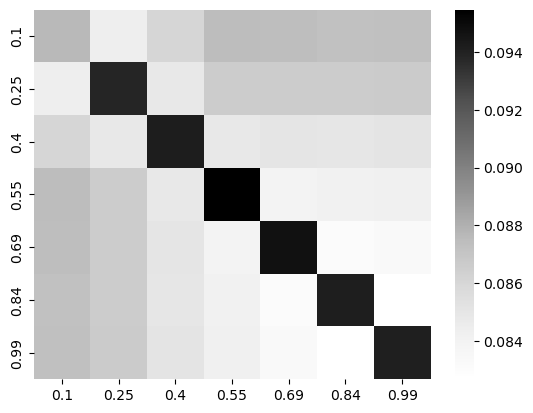

In [221]:
sns.heatmap(data=pd.DataFrame(tau_2_dis_matrix.adjacency.todense(), 
                              index=[np.around(i, decimals=2) for i in tau_2_dis_matrix.names], 
                              columns=[np.around(i, decimals=2) for i in tau_2_dis_matrix.names]),
           cmap="Greys")

# 5. Appendix: Analysis of Text Comparison Methods

- __Part 1__
    - analyze different ways of comparing the similarity of two sentences
        - Include: embedding, exact string match, approximate string matching
    - sentences should include: base sentence, sentence with formatting error, sentence with deliberate punctuation manipulation, paraphrase of sentence, sentence with word change for connotative effect, unrelated but similar sentence.

- __Part 2__
    - analyze how unrelated factors of text can contribute to erroneous similarity
        - use actual examples from the data, most especially sentences with quotes and sentences with prefacing information

In [21]:
def approximate_sentence_match(sent_1, sent_2):
    text_1 = nlp(sent_1)
    text_2 = nlp(sent_2)
    lemmas_1 = [i.lemma_.lower() for i in text_1 if (not i.is_stop) and (not i.is_punct) and (i.lemma_ != '-PRON-')]
    lemmas_2 = [i.lemma_.lower() for i in text_2 if (not i.is_stop) and (not i.is_punct) and (i.lemma_ != '-PRON-')]
    jaccard = len(set(lemmas_1).intersection(lemmas_2)) / float(len(set(lemmas_1).union(lemmas_2)))
    return jaccard

In [31]:
def filtered_word_embedding_sentence_match(sent_1, sent_2):
    text_1 = nlp(sent_1)
    text_2 = nlp(sent_2)
    lemmas_1 = [i.lemma_.lower() for i in text_1 if (not i.is_stop) and (not i.is_punct) and (i.lemma_ != '-PRON-')]
    lemmas_2 = [i.lemma_.lower() for i in text_2 if (not i.is_stop) and (not i.is_punct) and (i.lemma_ != '-PRON-')]
    similarity = nlp(" ".join(lemmas_1)).similarity(nlp(" ".join(lemmas_2)))
    return similarity

In [32]:
def sentiment_diff(sent_1, sent_2):
    sentiment_1 = sid.polarity_scores(sent_1)['compound']
    sentiment_2 = sid.polarity_scores(sent_2)['compound']

    return manhattan_distances(np.array(sentiment_1).reshape(-1, 1), np.array(sentiment_2).reshape(-1, 1))[0][0]

In [33]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
sid = SentimentIntensityAnalyzer()

### Part 1

In [34]:
base_sentence = "Three cadets at the U.S. Air Force Academy who have refused the COVID-19 vaccine will not be commissioned as military officers but will graduate with bachelor\'s degrees, the academy said Saturday."

In [35]:
sentences =[
    "Three cadets at the U.S. Air Force Academy who have refused the COVID-19 vaccine will not be commissioned as military officers, but will graduate with bachelor\'s degrees,\n the academy said Saturday.",
    "Three cadets at the U.S. Air Force Academy who have refused the COVID-19 vaccine will not be commissioned as military officers, but will graduate with bachelor\'s degrees, the academy said Saturday.",
    "Cadets at the U.S. Air Force Academy who have refused the COVID-19 vaccine will not be commissioned as military officers, but will graduate with bachelor\'s degrees, the academy said Saturday.",
    "Three cadets at the U.S. Air Force Academy who have \"refused\" the COVID-19 vaccine will not be commissioned as military officers but will graduate with bachelor\'s degrees, the academy said Saturday.",
    "The Air Force Academy said Saturday that the three cadets who refused the COVID-19 vaccine will not be commissioned as military officers but will graduate with bachelor\'s degrees.",
    "The Air Force Academy is requiring cadets to vaccinate against COVID-19 to commission.",
    "Three cadets at the U.S. Air Force Academy who declined the COVID-19 vaccine will not be commissioned as military officers, but will graduate with bachelor\'s degrees,\n the academy said Saturday.",
    "Three cadets at the U.S. Air Force Academy who have refused the COVID-19 vaccine will be denied commissions as military officers but will graduate with bachelor\'s degrees, the academy said Saturday.",
    "Three cadets at the U.S. Air Force Academy who have refused the COVID-19 vaccine will not be commissioned as military officers, the academy said Saturday.",
    "Three cadets at the U.S. Air Force Academy who have refused the COVID-19 vaccine will not be commissioned as military officers but will graduate with bachelor\'s degrees, a spokesman from the academy said Saturday.",
    "The U.S. Air Force Academy is located in Colorado Springs.",
    "Three cadets from the U.S. Air Force Academy, along with other commissioned military officers, presented at the graduate academy colloquium on COVID-19 vaccination among bachelors this Saturday.",
    "Tres cadetes de la Academia de la Fuerza Aérea de Estados Unidos que rechazaron la vacuna COVID-19 no serán comisionados como oficiales militares, pero se graduarán con una licenciatura, dijo la academia el sábado."
]

In [36]:
transforms = [
    "formatting typo",
    "inserted punctuation",
    "missing unimportant word",
    "framing with quotes",
    "rephrasing",
    "heavy rephrasing",
    "simple word change",
    "complex word change",
    "omission",
    "unimportant addition",
    "unrelated",
    "more similar unrelated",
    "foreign language"
]

In [44]:
comparison_df = pd.DataFrame(transforms, columns = ['text_alteration_technique'])
comparison_df['sentences'] = sentences

In [45]:
comparison_df['exact_match'] = comparison_df['sentences'].apply(lambda x: base_sentence == x)
comparison_df['approximate_match_jaccard'] = comparison_df['sentences'].apply(lambda x: approximate_sentence_match(base_sentence, x))
comparison_df['approximate_match_fuzzy'] = comparison_df['sentences'].apply(lambda x: fuzz.partial_ratio(base_sentence, x)/100)
comparison_df['approximate_match_word_embedding'] = comparison_df['sentences'].apply(lambda x: filtered_word_embedding_sentence_match(base_sentence, x))
comparison_df['embedding_cos_similarity'] = comparison_df['sentences'].apply(lambda x: cosine_similarity(model.encode(base_sentence).reshape(1, -1), model.encode(x).reshape(1, -1))[0][0])
comparison_df['sentiment_diff'] = comparison_df['sentences'].apply(lambda x:  sentiment_diff(base_sentence, x))

In [46]:
comparison_df

,text_alteration_technique,sentences,exact_match,approximate_match_jaccard,approximate_match_fuzzy,approximate_match_word_embedding,embedding_cos_similarity,sentiment_diff
0,formatting typo,Three cadets at the U.S. Air Force Academy who...,False,0.941176,0.99,1.000000,0.999288,0.0000
1,inserted punctuation,Three cadets at the U.S. Air Force Academy who...,False,1.000000,0.99,1.000000,0.999288,0.0000
2,missing unimportant word,Cadets at the U.S. Air Force Academy who have ...,False,1.000000,0.99,1.000000,0.951332,0.0000
3,framing with quotes,Three cadets at the U.S. Air Force Academy who...,False,1.000000,0.99,1.000000,0.987842,0.1531
4,rephrasing,The Air Force Academy said Saturday that the t...,False,0.937500,0.82,0.986345,0.972924,0.0000
5,heavy rephrasing,The Air Force Academy is requiring cadets to v...,False,0.333333,0.58,0.870449,0.664544,0.1531
6,simple word change,Three cadets at the U.S. Air Force Academy who...,False,0.833333,0.95,0.991498,0.995410,0.1531
7,complex word change,Three cadets at the U.S. Air Force Academy who...,False,0.941176,0.96,0.994235,0.981020,0.2185
8,omission,Three cadets at the U.S. Air Force Academy who...,False,0.812500,0.88,0.960710,0.942988,0.1429
9,unimportant addition,Three cadets at the U.S. Air Force Academy who...,False,0.941176,0.91,0.995795,0.983705,0.0000


In [47]:
comparison_df.to_csv("text_comp_results.csv")

### Part 2

In [49]:
base_sentence = "According to Rose, they did not do so because the vaccine, Novavax, is not yet FDA approved, and he added that it was not even clear that it was legally available to them."

In [50]:
sentences = [
    "According to the USAFA, 13 students have not received the COVID-19 vaccine, four of those are seniors, two are juniors, one is a sophomore, and six are freshmen.",
    'According to Dean Miller with the USAFA, the only option graduating seniors have is, "to obey the lawful order and receive the vaccine."',
    "According to Seuss, Nathan had a wedding planned for two weeks post-graduation and a deployment plan near where his future bride resides.",
    "According to Suess, his son has also been told he has to pay back around $160,000 in education costs if he refuses the vaccine.",
    "According to the Air Force Academy, all cadets agree to these enrollment agreements:."
]

In [51]:
comparison_df = pd.DataFrame(sentences, columns = ['sentences'])

In [52]:
comparison_df['exact_match'] = comparison_df['sentences'].apply(lambda x: base_sentence == x)
comparison_df['approximate_match_jaccard'] = comparison_df['sentences'].apply(lambda x: approximate_sentence_match(base_sentence, x))
comparison_df['approximate_match_fuzzy'] = comparison_df['sentences'].apply(lambda x: fuzz.partial_ratio(base_sentence, x)/100)
comparison_df['approximate_match_word_embedding'] = comparison_df['sentences'].apply(lambda x: filtered_word_embedding_sentence_match(base_sentence, x))
comparison_df['embedding_cos_similarity'] = comparison_df['sentences'].apply(lambda x: cosine_similarity(model.encode(base_sentence).reshape(1, -1), model.encode(x).reshape(1, -1))[0][0])
comparison_df['sentiment_diff'] = comparison_df['sentences'].apply(lambda x:  sentiment_diff(base_sentence, x))

In [53]:
comparison_df

,sentences,exact_match,approximate_match_jaccard,approximate_match_fuzzy,embedding_cos_similarity,sentiment_diff
0,"According to the USAFA, 13 students have not r...",False,0.105263,0.45,0.343863,0.4795
1,"According to Dean Miller with the USAFA, the o...",False,0.100000,0.45,0.393356,0.4795
2,"According to Seuss, Nathan had a wedding plann...",False,0.045455,0.45,0.084408,0.4795
3,"According to Suess, his son has also been told...",False,0.105263,0.49,0.262580,0.3768
4,"According to the Air Force Academy, all cadets...",False,0.058824,0.49,0.086818,0.8407
